In [65]:
from __future__ import division
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats as sps
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
credit_story = pd.read_csv('credit_card_default_analysis.csv')
credit_story.head()

,ID,LIMIT_BAL,GENDER,EDUCATION,MARITAL,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_JUN,BILL_MAY,BILL_APR,PAY_SEP.1,PAY_AUG.1,PAY_JUL.1,PAY_JUN.1,PAY_MAY.1,PAY_APR.1,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 1. Credit limit: test whether there are differences between median credit limits of two groups.

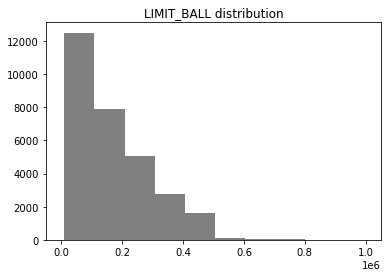

In [71]:
plt.plot(125);
plt.title('LIMIT_BALL distribution');
plt.hist(credit_story['LIMIT_BAL'], color = 'gray');

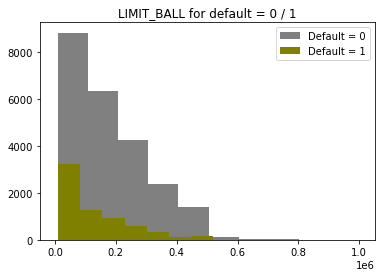

In [16]:
plt.plot(125);
plt.title('LIMIT_BALL distribution for default = 0 / 1');
plt.hist(credit_story.LIMIT_BAL.loc[credit_story.default == 0], color = 'gray', label='Default = 0');
plt.hist(credit_story.LIMIT_BAL.loc[credit_story.default == 1], color = 'olive', label='Default = 1');
plt.legend();

#people tend to pay off bigger amounts

In [10]:
# H_o -- medians are equal
# H_a -- nediands aren't equal


lim_bal_0 = credit_story.LIMIT_BAL.loc[credit_story.default == 0]
lim_bal_1 = credit_story.LIMIT_BAL.loc[credit_story.default == 1]

print('Median LIMIT_BAL for default = 0: %.0f' % lim_bal_0.median())
print('Median LIMIT_BAL for default = 1: %.0f' % lim_bal_1.median())

Median LIMIT_BAL for default = 0: 150000
Median LIMIT_BAL for default = 1: 90000


In [12]:
# binomial distribution

def zconfint_binom(n, p, alpha=0.05):
    q = 1 - p
    m = n * p
    var = n * p * q
    z_stat = stats.norm.ppf(1 - alpha / 2)
    l_bound = int(round(m - z_stat * np.sqrt(var)))
    u_bound = int(round(m + z_stat * np.sqrt(var)))
    return (l_bound, u_bound)

In [13]:
lim_bal_0_s = np.sort(lim_bal_0.values)
lim_bal_1_s = np.sort(lim_bal_1.values)

l_ind_0, u_ind_0 = zconfint_binom(len(lim_bal_0_s), 0.5)
l_ind_1, u_ind_1 = zconfint_binom(len(lim_bal_1_s), 0.5)

print('Conf. int. median LIMIT_BAL for default = 0: [%d, %d]' % (lim_bal_0_s[l_ind_0], lim_bal_0_s[u_ind_0]))
print('Conf. int. median LIMIT_BAL for default = 1: [%d, %d]' % (lim_bal_1_s[l_ind_1], lim_bal_1_s[u_ind_1]))

Conf. int. median LIMIT_BAL for default = 0: [150000, 150000]
Conf. int. median LIMIT_BAL for default = 1: [80000, 90000]


In [55]:
# bootstrap

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [17]:
np.random.seed(0)

lim_bal_0_bs_med = list(map(np.median, get_bootstrap_samples(lim_bal_0.values, 100)))
lim_bal_1_bs_med = list(map(np.median, get_bootstrap_samples(lim_bal_1.values, 100)))

bnd_0 = stat_intervals(lim_bal_0_bs_med, 0.05)
bnd_1 = stat_intervals(lim_bal_1_bs_med, 0.05)

print('Conf. int. median LIMIT_BAL for default = 0: [%d, %d]' % (bnd_0[0], bnd_0[1]))
print('Conf. int. median LIMIT_BAL for default = 1: [%d, %d]' % (bnd_1[0], bnd_1[1]))

Conf. int. median LIMIT_BAL for default = 0: [150000, 150000]
Conf. int. median LIMIT_BAL for default = 1: [80000, 90000]


In [ ]:
# medians are different: people who don't pay back tend to take less money

In [ ]:
H_o -- sample distributions are equal
H_a -- sample distributions are shifted

In [67]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [68]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [69]:
def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)


In [25]:
print('p-value: %f' % permutation_test(lim_bal_0, lim_bal_1, max_permutations=1000))

p-value: 0.001000


In [ ]:
# we reject null hypothesis with alpha = 0.05 Difference in medians LIMIT_BALL is significant

## 2. Gender: test whether gender composition of two groups differ.

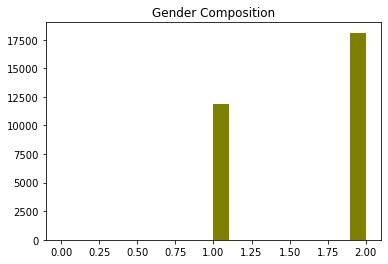

In [72]:
plt.plot(130);
plt.title('Gender Composition');
plt.hist(credit_story['GENDER'], color = 'olive');

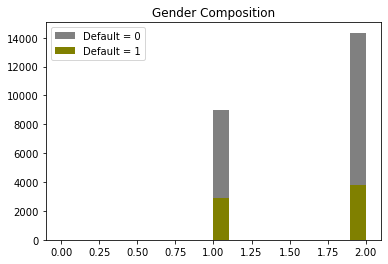

In [10]:
plt.plot(130);
plt.title('Gender Composition');
plt.hist(credit_story.GENDER.loc[credit_story.default == 0], color = 'gray', label='Default = 0');
plt.hist(credit_story.GENDER.loc[credit_story.default == 1], color = 'olive', label='Default = 1');
plt.legend();

# women tend to be among non-payers more often than men

Let's check hypothesis that proportion of payers and non-payers is different. For this, I'll find confidence intervalse for payers, non-payers, and the difference.

In [16]:
#samples of gender for default = 0/1
gender_0 = credit_story.GENDER.loc[credit_story.default == 0].values
gender_1 = credit_story.GENDER.loc[credit_story.default == 1].values

#proportions of men to women in samples
m_to_w_0 = np.where(gender_0 == 1)[0].shape[0] / gender_0.shape[0]
m_to_w_1 = np.where(gender_1 == 1)[0].shape[0] / gender_1.shape[0]

print('proportions of men for default = 0: %.4f' % m_to_w_0)
print('proportions of men for default = 1: %.4f' % m_to_w_1)

proportions of men for default = 0: 0.3859
proportions of men for default = 1: 0.4329


In [19]:
#confidence intervals for proportions
conf_int_0 = proportion_confint(np.where(gender_0 == 1)[0].shape[0], gender_0.shape[0])
conf_int_1 = proportion_confint(np.where(gender_1 == 1)[0].shape[0], gender_1.shape[0])

print('confidence interval for proportions of men or default = 0: [%.4f, %.4f]' % conf_int_0)
print('confidence interval for proportions of men or default = 1: [%.4f, %.4f]' % conf_int_1)

# since confidence intervals don't intercept, I can conclude that genders are different 

confidence interval for proportions of men or default = 0: [0.3796, 0.3921]
confidence interval for proportions of men or default = 1: [0.4210, 0.4449]


In [20]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left_boundary, right_boundary)

print('confidence interval for difference: [%f, %f]' % proportions_confint_diff_ind(np.abs(sex_0-2), np.abs(sex_1-2)))

confidence interval for difference: [-0.060548, -0.033635]


Let's take a Z-test for two independent samples.
H_o: gender distribution is the same
H_a: gender distribution is not the same    

In [21]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [22]:
print('p-value: %.15f' % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(sex_0-2), np.abs(sex_1-2))))

# we reject H_o and find the result practically significant 

p-value: 0.000000000004473


## 3. Education: test whether education levels differs between two groups. If it does, then how exactly?

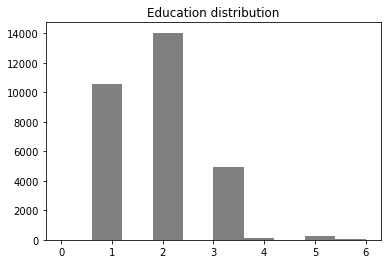

In [28]:
plt.plot(125)
plt.title('Education distribution');
plt.hist(credit_story['EDUCATION'], color = 'grey');

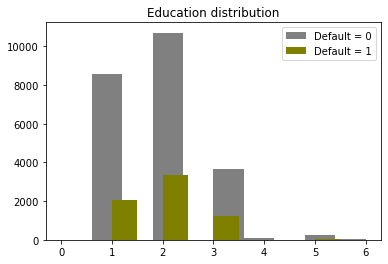

In [24]:
plt.plot(125);
plt.title('Education distribution');
plt.hist(credit_story.EDUCATION.loc[credit_story.default == 0], color = 'gray', label='Default = 0');
plt.hist(credit_story.EDUCATION.loc[credit_story.default == 1], color = 'olive', label='Default = 1');
plt.legend();

# we see that normally people with Bachelor's and Master's degree take loans, but I can't see much difference 
# in proportions of payers and non-payers

Let's check if the level of education influences whether or not a person will pay back a loan.

proportions of default = 0 for education = 0: 1.00
proportions of default = 0 for education = 1: 0.81
proportions of default = 0 for education = 2: 0.76
proportions of default = 0 for education = 3: 0.75
proportions of default = 0 for education = 4: 0.94
proportions of default = 0 for education = 5: 0.94
proportions of default = 0 for education = 6: 0.84


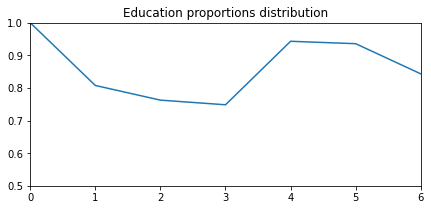

In [31]:
# histogram for proportion of paid back credits

#samples of education for default = 0/1
edu = credit_story.EDUCATION
edu_0 = credit_story.EDUCATION.loc[credit_story.default == 0]
edu_1 = credit_story.EDUCATION.loc[credit_story.default == 1]

#proportions of paid back credit
edu_prop = np.empty( (len(np.unique(edu_0)), 2) )
for i, ed_val in enumerate(np.unique(edu)):
    edu_prop[i, 0] = ed_val
    edu_prop[i, 1] = edu_0[edu_0 == ed_val].shape[0] / (edu_0[edu_0 == ed_val].shape[0] + edu_1[edu_1 == ed_val].shape[0])

for ed_val, prop in edu_prop:
    print('proportions of default = 0 for education = %d: %.2f' % (ed_val, prop))

#histogram of education proportions distribution
plt.figure(1, figsize=(7,3));
plt.title('Education proportions distribution');
plt.plot(edu_prop[:,0], edu_prop[:,1]);
plt.axis([0, 6, 0.5, 1]);

We see from the graph that the destribution isn't normal with only PhD returning all the credits. Bachelor's and High school levels are most unlikely to pay back.

Let's take a Pearson's test with H_0 -- it doesn't have normal distribution against H_a that H_0 is false.
Let's calculate the mean value of credits return among customers with different education level.

In [33]:
mean = edu_prop[:,1].mean()
print('Mean proportion: %.2f' % mean)

Mean proportion: 0.86


In [34]:
#sample sizes for different education levels

edu_num_0 = np.array([edu_0[edu_0 == ed_val].shape[0] for ed_val in range(7)])
edu_num_1 = np.array([edu_1[edu_1 == ed_val].shape[0] for ed_val in range(7)])
edu_num = edu_num_0 + edu_num_1

for i in range(7):
    print('education level %d: %d / %d | %d' % (i, edu_num_0[i], edu_num_1[i], edu_num[i]))
print('Legend: deafault = 0 / default = 1 | total')

education level 0: 14 / 0 | 14
education level 1: 8549 / 2036 | 10585
education level 2: 10700 / 3330 | 14030
education level 3: 3680 / 1237 | 4917
education level 4: 116 / 7 | 123
education level 5: 262 / 18 | 280
education level 6: 43 / 8 | 51
Legend: deafault = 0 / default = 1 | total


In [36]:
#expected frequencies

exp_freq = np.array([mean * edu_num[i] for i in range(7)])

for i in range(7):
    print('education level %d: %d / %d | %d' % (i, exp_freq[i], edu_num_0[i], edu_num_0[i] - exp_freq[i]))
print('Legend: exp freq / obs freq = 1 | delta')

education level 0: 12 / 14 | 1
education level 1: 9134 / 8549 | -585
education level 2: 12107 / 10700 | -1407
education level 3: 4243 / 3680 | -563
education level 4: 106 / 116 | 9
education level 5: 241 / 262 | 20
education level 6: 44 / 43 | -1
Legend: exp freq / obs freq = 1 | delta


In [37]:
#chi-square test

stats.chisquare(edu_num_0, exp_freq, ddof = 1)

Power_divergenceResult(statistic=278.7725391716089, pvalue=3.653181595163598e-58)

In [39]:
# we reject the hypothesis of equal distribution -- the return percentage differs a lot among people 
# with different levels of education.

## 4.    Marital status: Check how marital status is related to the default indicator: you need to propose a measure by which you can measure the possible relationship of these variables and calculate its value.

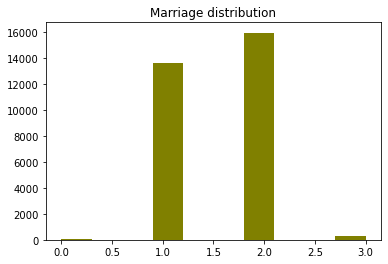

In [43]:
plt.plot(120);
plt.title('Marriage distribution');
plt.hist(credit_story['MARITAL'], color = 'olive');

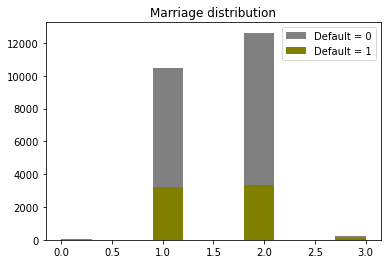

In [44]:
plt.plot(120);
plt.title('Marriage distribution');
plt.hist(credit_story.MARITAL.loc[credit_story.default == 0], color = 'gray', label='Default = 0');
plt.hist(credit_story.MARITAL.loc[credit_story.default == 1], color = 'olive', label='Default = 1');
plt.legend();

# there is about 10% difference between return rate in married and single people

In [45]:
#samples of MARITAL for default = 0/1

marital = credit_story.MARITAL
marital_0 = credit_story.MARITAL.loc[credit_story.default == 0]
marital_1 = credit_story.MARITAL.loc[credit_story.default == 1]

print('Value counts for marriage:')
marital.value_counts()

Value counts for marriage:


2    15964
1    13659
3      323
0       54
Name: MARITAL, dtype: int64

In [46]:
conf_matrix = np.empty( (len(marital.value_counts()), 2) )
for i in range(len(marital.value_counts())):
    conf_matrix[i, 0] = len(marital_0.loc[marital_0 == i])
    conf_matrix[i, 1] = len(marital_1.loc[marital_1 == i])
print(conf_matrix)

[[4.9000e+01 5.0000e+00]
 [1.0453e+04 3.2060e+03]
 [1.2623e+04 3.3410e+03]
 [2.3900e+02 8.4000e+01]]


In [47]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

print('V Cramer stat value: %.4f' % cramers_stat(conf_matrix))

# I believe that confusion matrix and Cramer's V is beyond the scope of our course. 
# For Cramer's V (coefficient) please refer to https://wiki5.ru/wiki/Cram%C3%A9r's_V
# For confusion matrix, to our ML course at Udemy we all took last year

V Cramer stat value: 0.0345


Crammer's V close to zero means there is no association between variables.  Therefore, it doesn't matter whether a person is married or not. 

## 5. Age: test whether there are differences between mean ages of clients in two groups.

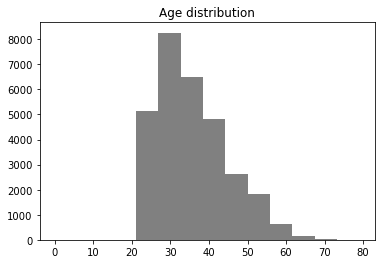

In [49]:
plt.plot(125);
plt.title('Age distribution');
plt.hist(credit_story['AGE'], color = 'gray');

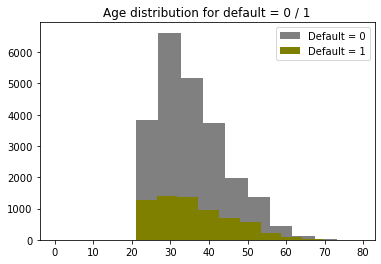

In [51]:
plt.plot(125);
plt.title('Age distribution for default = 0 / 1');
plt.hist(credit_story.AGE.loc[credit_story.default == 0], color = 'gray', label='Default = 0');
plt.hist(credit_story.AGE.loc[credit_story.default == 1], color = 'olive', label='Default = 1');
plt.legend();

# interestingly, people of age 30 tend to have the most of credits taken. However, there is no such difference 
# in age between those who didn't pay back.

In [52]:
# let's test H_0 -- medians are equal against H_a -- medians are different

age_0 = credit_story.AGE.loc[credit_story.default == 0]
age_1 = credit_story.AGE.loc[credit_story.default == 1]

print('Median AGE for default = 0: %.0f' % age_0.median())
print('Median AGE for default = 1: %.0f' % age_1.median())

Median AGE for default = 0: 34
Median AGE for default = 1: 34


In [59]:
# bootstrap
# confidence intervals estimation

np.random.seed(0)

age_0_bs_med = list(map(np.median, get_bootstrap_samples(age_0.values, 100)))
age_1_bs_med = list(map(np.median, get_bootstrap_samples(age_1.values, 100)))

bnd_0 = stat_intervals(age_0_bs_med, 0.05)
bnd_1 = stat_intervals(age_1_bs_med, 0.05)

print('confidence interval median AGE for default = 0: [%f, %f]' % (bnd_0[0], bnd_0[1]))
print('confidence interval median AGE for default = 1: [%f, %f]' % (bnd_1[0], bnd_1[1]))

# medians intersect

confidence interval median AGE for default = 0: [34.000000, 34.000000]
confidence interval median AGE for default = 1: [34.000000, 35.000000]


In [58]:
print('Difference between medians: %f' % (np.median(age_0) - np.median(age_1)))

Difference between medians: 0.000000


In [61]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_0_bs_med, age_1_bs_med)))
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% confidence interval for the difference between medians: [%f, %f]' % (stat_int[0], stat_int[1]))

# because of confidence interval containing 0, I conclude that there is no differences in medians.

95% confidence interval for the difference between medians: [0.000000, 1.000000]


let's do a permutation test for independemt samples
H_0 -- sample distributions are equal
H_a -- sample distributions differ 

In [70]:
print('p-value: %f' % permutation_test(age_0, age_1, max_permutations=1000))

p-value: 0.014000


We reject H_0 and confirm that age should be taken into consideration.